In [1]:
import os

import h5py
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
sns.set_context('notebook')

import sklearn
from sklearn import datasets
from sklearn.metrics.pairwise import pairwise_kernels
import graphtools
#from pydiffmap.diffusion_map import DiffusionMap
import phate

os.chdir('..')
from diffusion_maps import compute_dm, plot_change_in_diffusion_distance, compute_diffusion_distance_direct, compute_diffusion_distance_using_dmcoords, display_powers_of_diff_op
from graph_utils import get_graph_representation, plot_graph, get_groups_from_graph
import manifold_methods
import plotting
import mappings
import data_loader

In [2]:
def plot_components(dm_comps, components, labels, mapping, label_order, cont_var=None):
    # Create a figure and axis
    fig, ax = plt.subplots(ncols=len(components), figsize=(4*len(components), 4))
    
    # Shuffle labels and data to remove artifact of data ordering
    r_idx = np.arange(len(dm_comps))
    np.random.shuffle(r_idx)
    dm_comps = dm_comps[r_idx]
    labels = labels[r_idx]
    if not cont_var is None:
        cont_var = cont_var[r_idx]

    for i, component in enumerate(components):
        dm_comp = np.round(dm_comps[:,component], 8)
        idxs = np.argsort(dm_comp)
        sorted_labels = labels[idxs]
        if not cont_var is None:
            sorted_cont_var = cont_var[idxs]
            # ignore mapping
            cmap_used = sns.color_palette('Reds', as_cmap=True)
            colors = [cmap_used(label) for label in sorted_cont_var]
        else:
           # Get colors for each sample based on sorted superpopulation labels
            colors = [mapping[label] for label in sorted_labels]

        # Plot the sorted labels array
        #ax[i].scatter(range(len(sorted_labels)), [0] * len(sorted_labels), c=colors, s=50, alpha=1)
        ax[i].bar(range(len(sorted_labels)), [1] * len(sorted_labels), color=colors, width=1, edgecolor='none')

        # Set title and labels
        ax[i].set_title('DM {}'.format(component))
        #ax[i].set_xlabel('Sample Index')
        ax[i].set_yticks([])  # Hide y-axis

    # Create a legend
    if cont_var is None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=mapping[label], 
                              markersize=10) for label in label_order]
        ax[i].legend(handles, label_order, title='Superpopulation', bbox_to_anchor=(1.1, 1.05), loc='upper left')

    plt.show()

In [3]:
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/1KGP/WGS30X_V1/oldnow/MattsPlace'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [4]:
with h5py.File(os.path.join(exp_path, fname), 'r') as hf:
    #model_attrs = hf['gradients'][:]
    #print('loaded gradient of fc1 w.r.t. input from {}'.format(attr_fc1_saliency_name))
    inputs = hf['inputs'][:]
    class_label_names = hf['class_label_names'][:]
    class_labels = hf['class_labels'][:]
    samples = hf['samples'][:]
    snp_names = hf['snp_names'][:]
    
# make labels
label_with_names = [str(class_label_names[y])[2:-1] for y in class_labels]
class_label_names = [str(label)[2:-1] for label in class_label_names]

label_with_superpop_names = np.zeros_like(label_with_names)
for label in mappings.super_pops_1000G:
    index = pd.DataFrame(label_with_names).isin(mappings.super_pops_1000G[label]).values.flatten()
    label_with_superpop_names[index] = label

## Look at all populations

In [5]:
G = graphtools.Graph(inputs, n_pca=100, n_landmark=None)
K = G.kernel
K = np.array(K.todense())
P = G.diff_op

Vary Alpha

In [6]:
# alpha=0 Graph Laplacian
evecs_right, evals, P2, d = compute_dm(K, alpha=0)
diffusion_coords = evecs_right@np.diag(evals)

537 eigenvalues are negative: min=-0.24398004281381214
4 eigenvalues are 1
left evec not exactly stationary dist. Proceed with caution!
right evec not trivial (1s)! Proceed with caution!


Compare with diffusion operator

In [7]:
# alpha=0.5 Fokker-Plank operator
evecs_right_fp, evals_fp, P_fp, d_fp = compute_dm(K, alpha=0.5)
diffusion_coords_fp = evecs_right_fp@np.diag(evals_fp)

537 eigenvalues are negative: min=-0.2211996716042749
4 eigenvalues are 1
left evec not exactly stationary dist. Proceed with caution!
right evec not trivial (1s)! Proceed with caution!


In [8]:
# alpha=1 Laplace-Beltrami operator
evecs_right_lb, evals_lb, P_lb, d_lb = compute_dm(K, alpha=1)
diffusion_coords_lb = evecs_right_lb@np.diag(evals_lb)

537 eigenvalues are negative: min=-0.20734520347843638
4 eigenvalues are 1
left evec not exactly stationary dist. Proceed with caution!
right evec not trivial (1s)! Proceed with caution!


## Analyze Trajectories

In [9]:
#α=1: This setting approximates the Laplace-Beltrami operator, 
# which is useful for identifying long-term population migrations. 
# It captures the global structure and is more sensitive to the geometry of the underlying manifold.
# JC: EUR-SAS-EAS cline

#𝛼=0.5: This setting approximates the Fokker-Planck operator, 
# which can correspond to admixture information. 
# It balances between local and global structures, 
# making it suitable for detecting more complex dynamics like gene flow and admixture.
# JC: AFR-AMR-EUR

# JC: Overall signals could be similar, but would be more aparant when doing fine grained analysis?

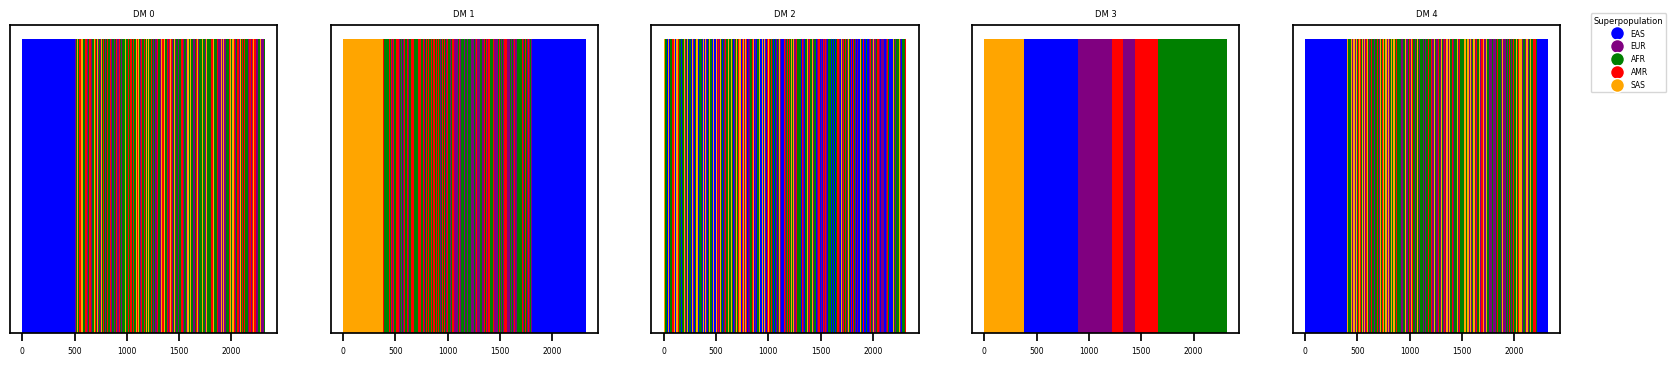

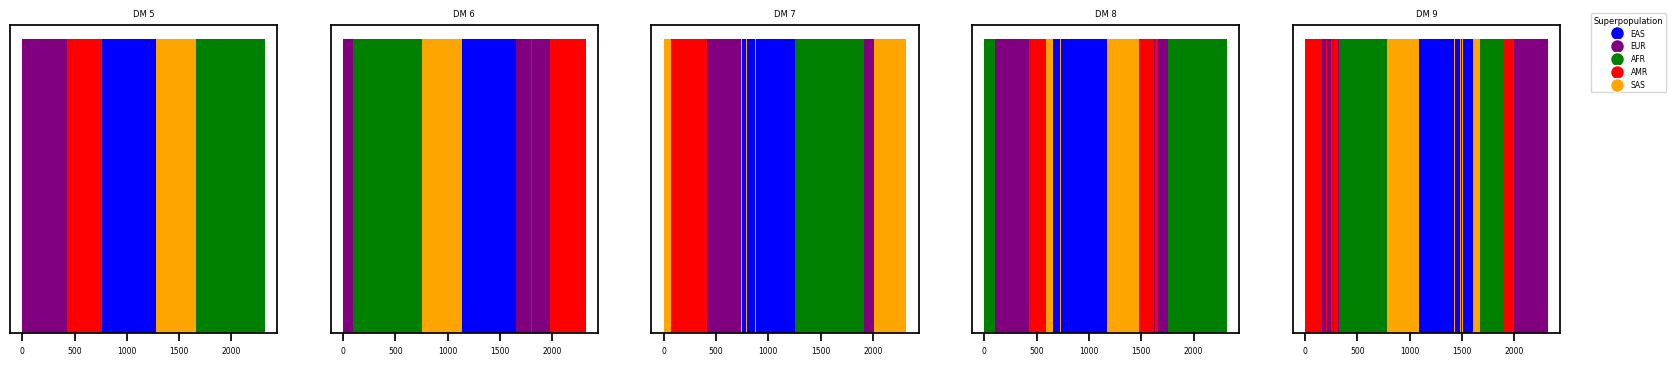

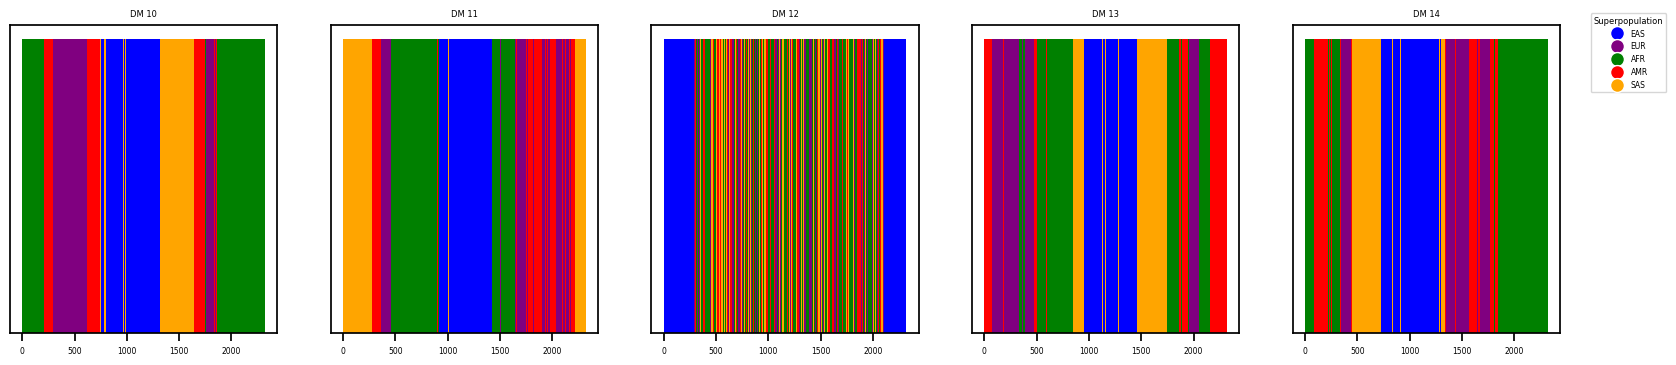

In [10]:
# LB
plot_components(diffusion_coords_lb, [0,1,2,3,4], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)
plot_components(diffusion_coords_lb, [5,6,7,8,9], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)
plot_components(diffusion_coords_lb, [10,11,12,13,14], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)

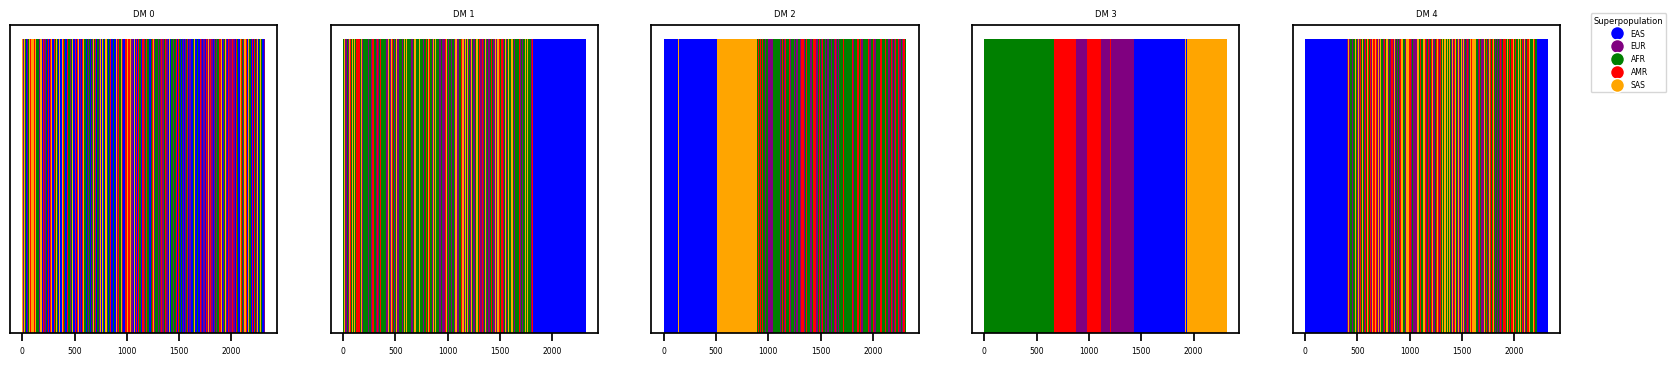

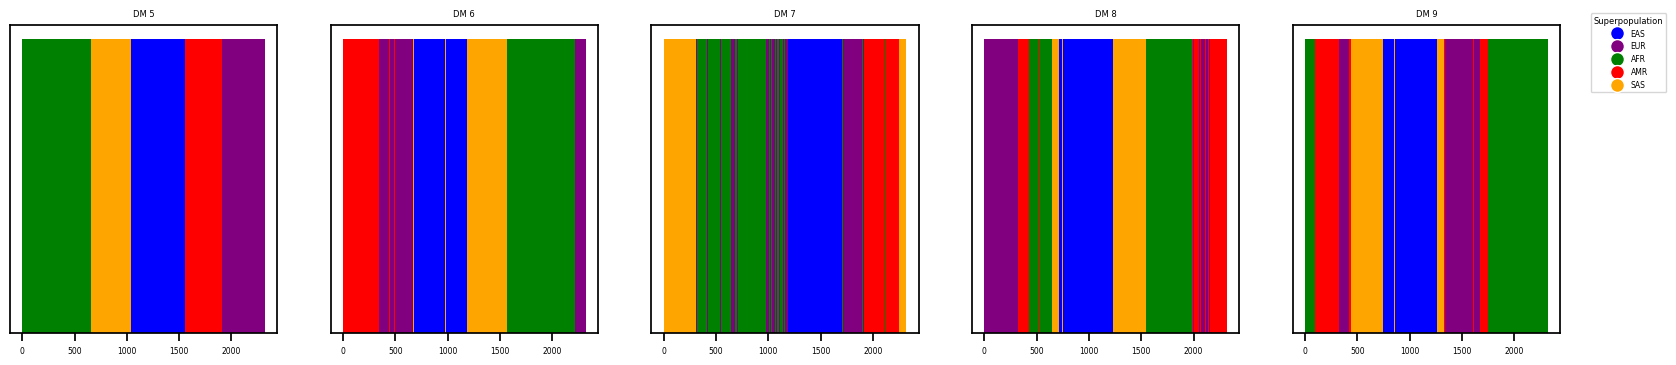

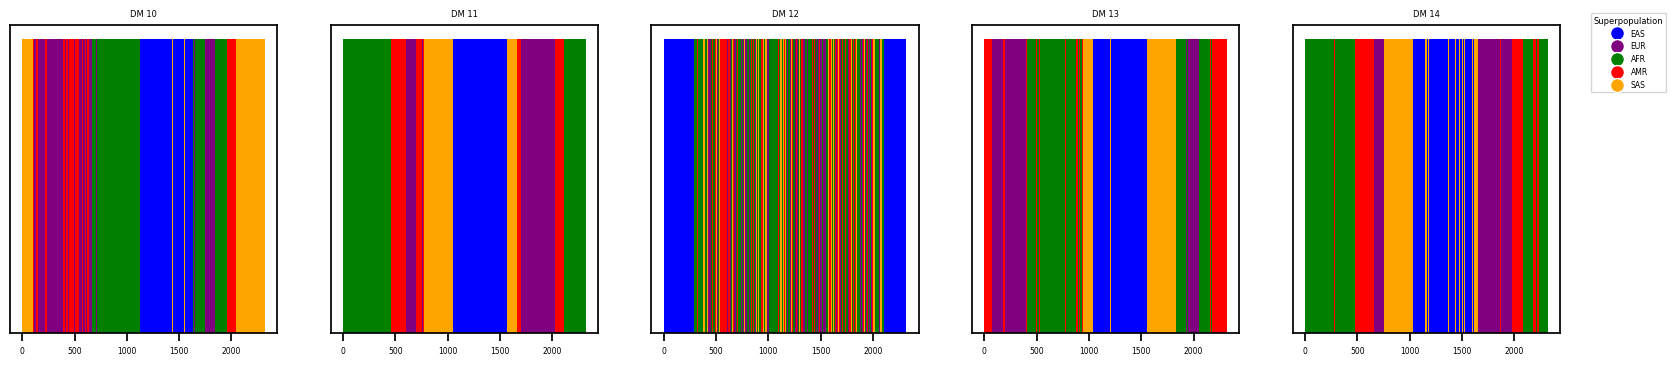

In [11]:
# FP
plot_components(diffusion_coords_fp, [0,1,2,3,4], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)
plot_components(diffusion_coords_fp, [5,6,7,8,9], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)
plot_components(diffusion_coords_fp, [10,11,12,13,14], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)

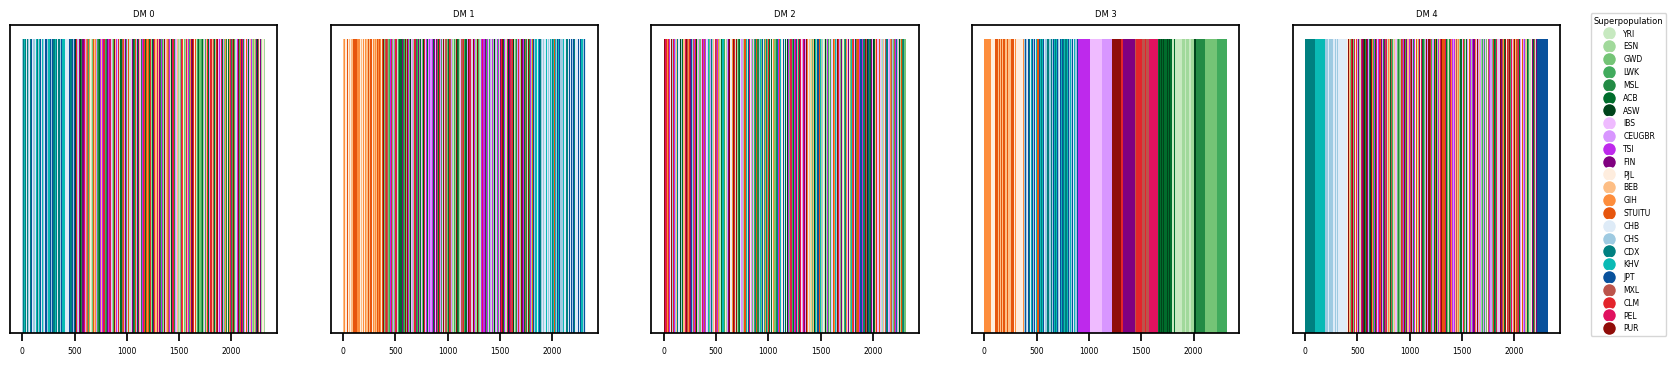

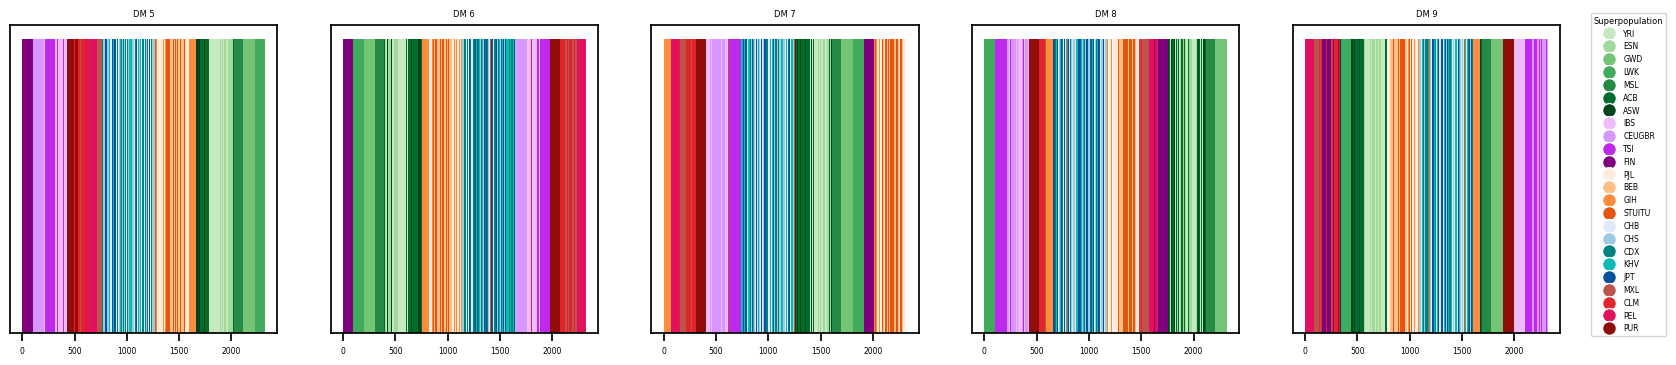

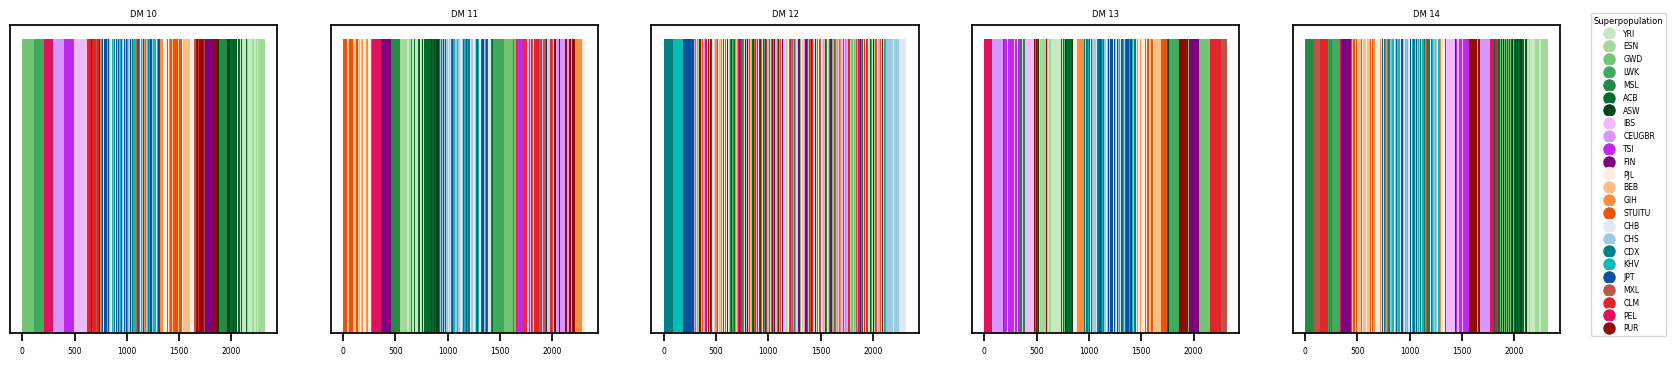

In [12]:
# LB
plot_components(diffusion_coords_lb, [0,1,2,3,4], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)
plot_components(diffusion_coords_lb, [5,6,7,8,9], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)
plot_components(diffusion_coords_lb, [10,11,12,13,14], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)

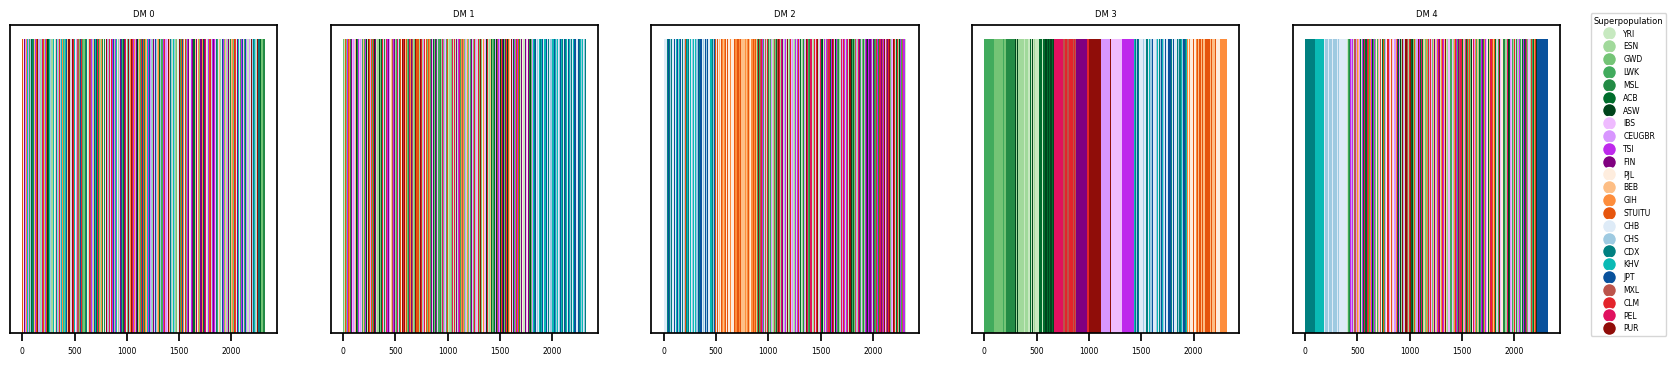

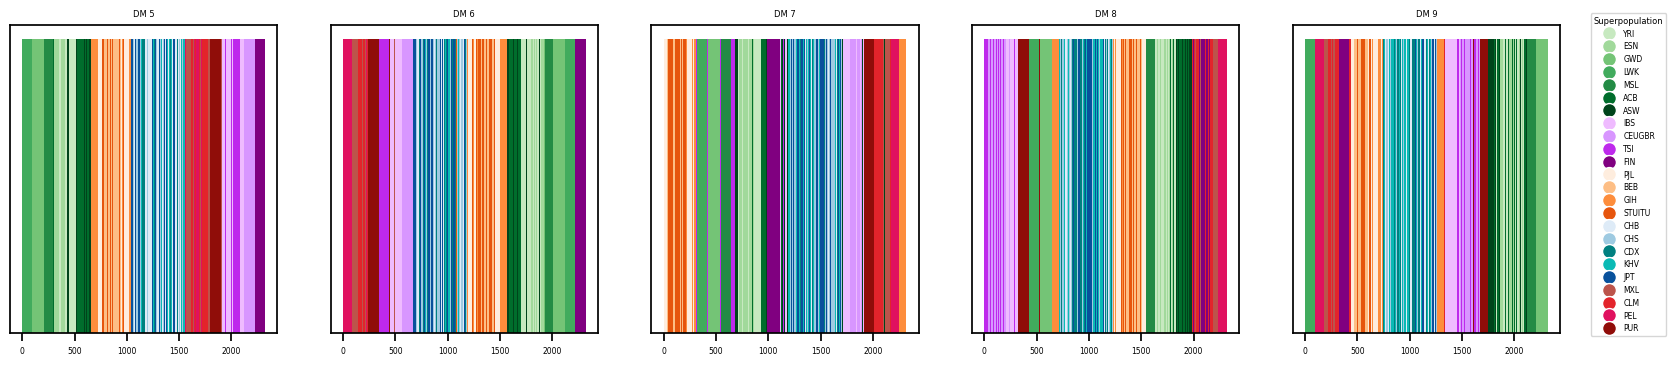

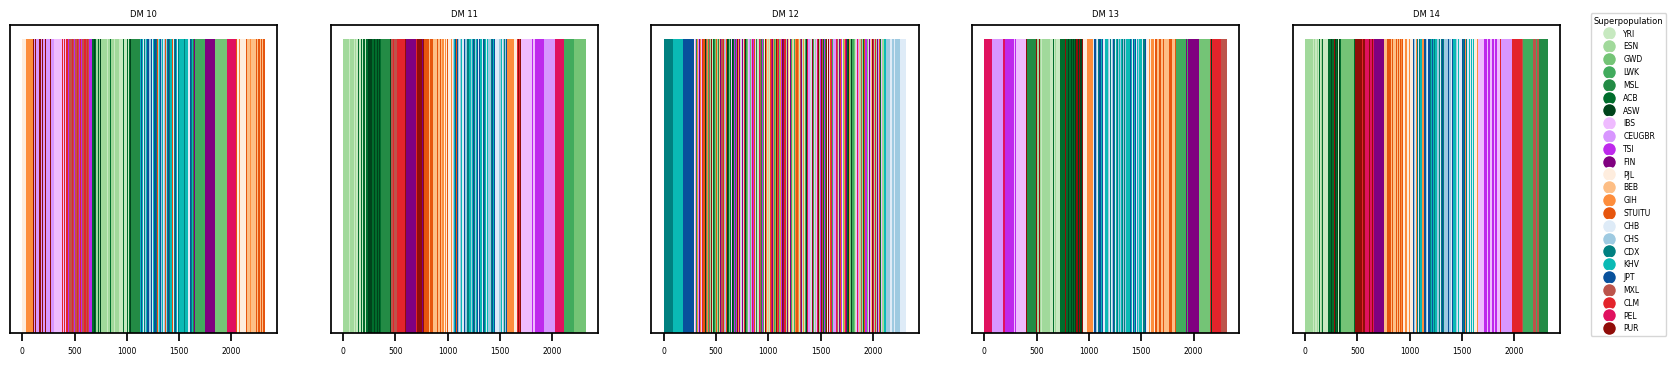

In [13]:
# FP
plot_components(diffusion_coords_fp, [0,1,2,3,4], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)
plot_components(diffusion_coords_fp, [5,6,7,8,9], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)
plot_components(diffusion_coords_fp, [10,11,12,13,14], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)

In [14]:
# Now plot admix ratios

sample_ids = pd.read_csv('notebooks/MyAdmix/output_ids.txt', sep=' ', header=None)
admix_ratios = pd.read_csv('notebooks/MyAdmix/AMR_ACB_ASW.3.Q', sep=' ', header=None)

admix_labels_custom = np.zeros([len(label_with_names), 3])
admix_df = pd.concat([admix_ratios, sample_ids], axis=1)
admix_df.columns = ['admix 1', 'admix 2', 'admix 3' , 'sample id']

labels2 = np.array([sample.decode("utf-8") for sample in samples])
matching_indices = np.array([np.where(admix_df['sample id'][j] == labels2)[0][0] if len(np.where(admix_df['sample id'][j] == labels2)[0]) > 0 else -1 for j in range(len(admix_df))])

for i, idx in enumerate(matching_indices):
    if idx != -1:
        admix_labels_custom[idx] = admix_df.iloc[i].values[:3]
        
admix_labels_custom2 = admix_labels_custom
admix_labels_custom2[label_with_superpop_names == 'EUR', 2] = 1
admix_labels_custom2[label_with_superpop_names == 'AFR', 0] = 1

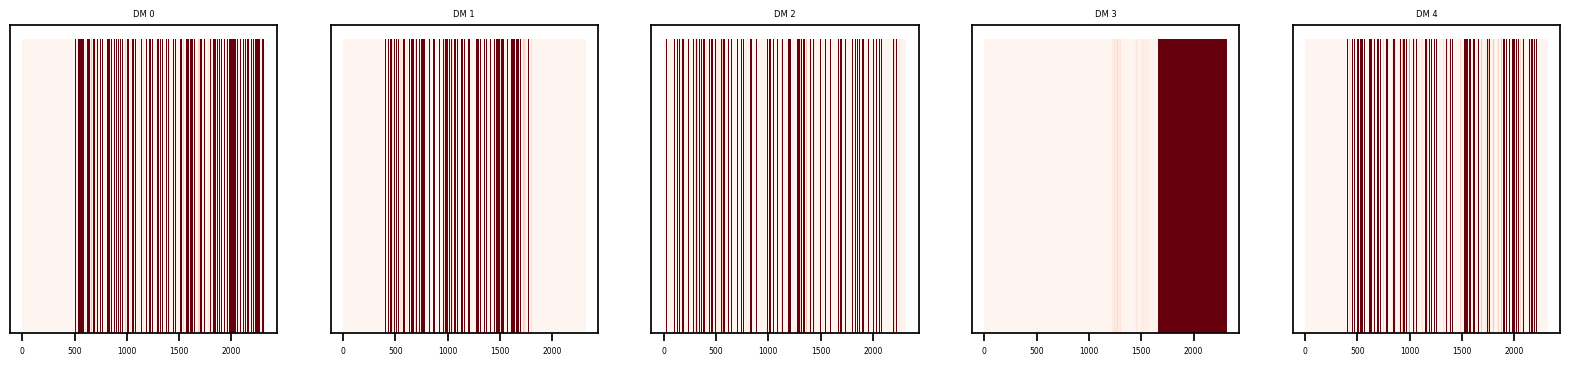

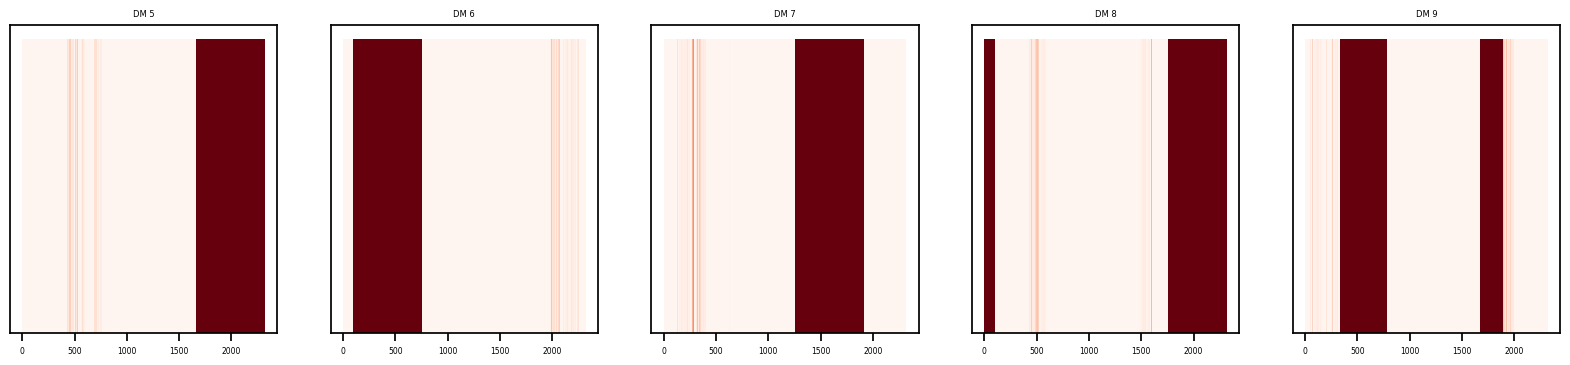

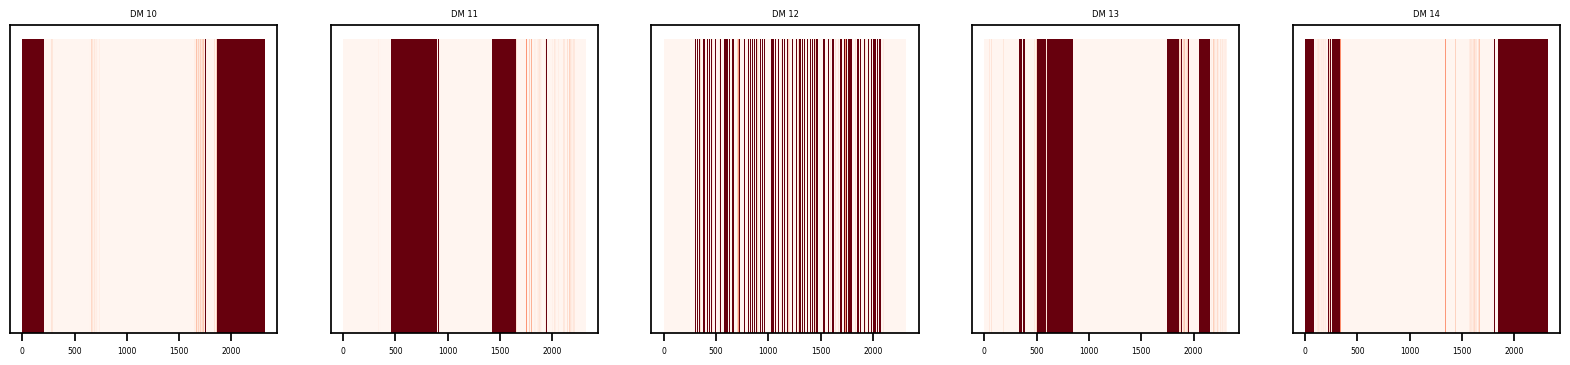

In [15]:
# "Amerindigenous ancestry (%)"
plot_components(diffusion_coords_lb, [0,1,2,3,4], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse,
                admix_labels_custom2[:,0])
plot_components(diffusion_coords_lb, [5,6,7,8,9], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse,
                admix_labels_custom2[:,0])
plot_components(diffusion_coords_lb, [10,11,12,13,14], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse,
                admix_labels_custom2[:,0])

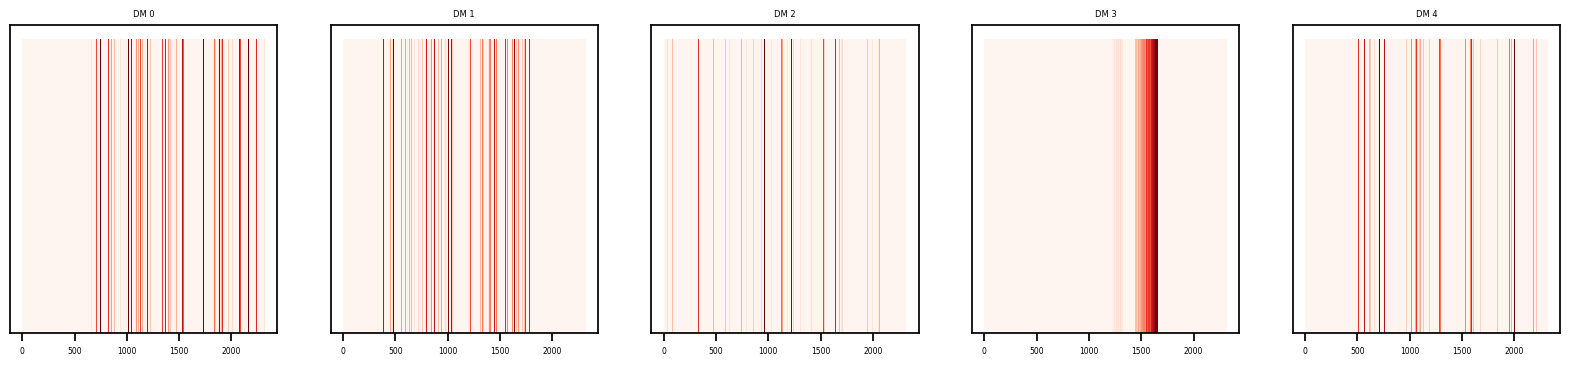

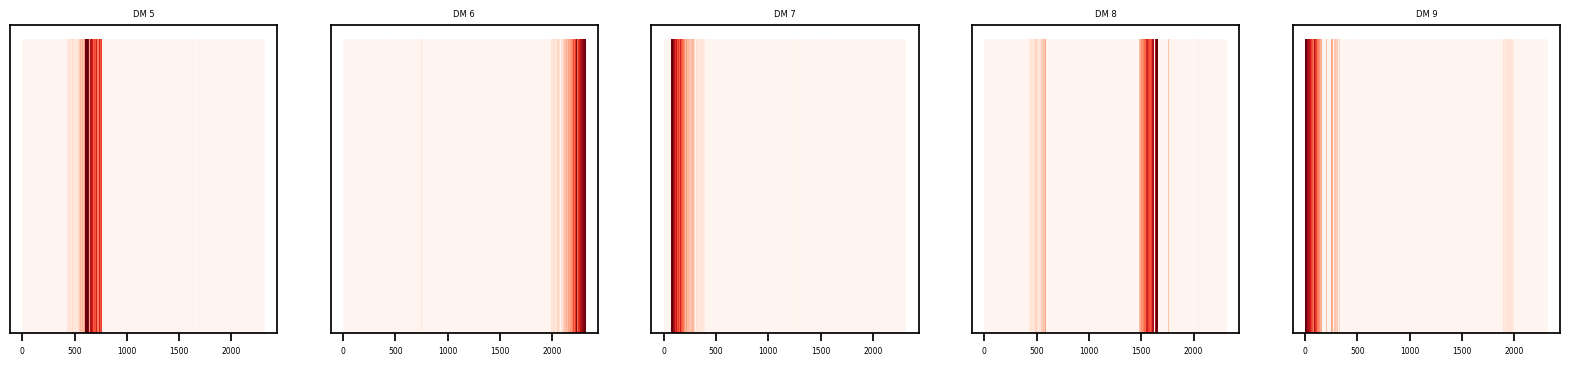

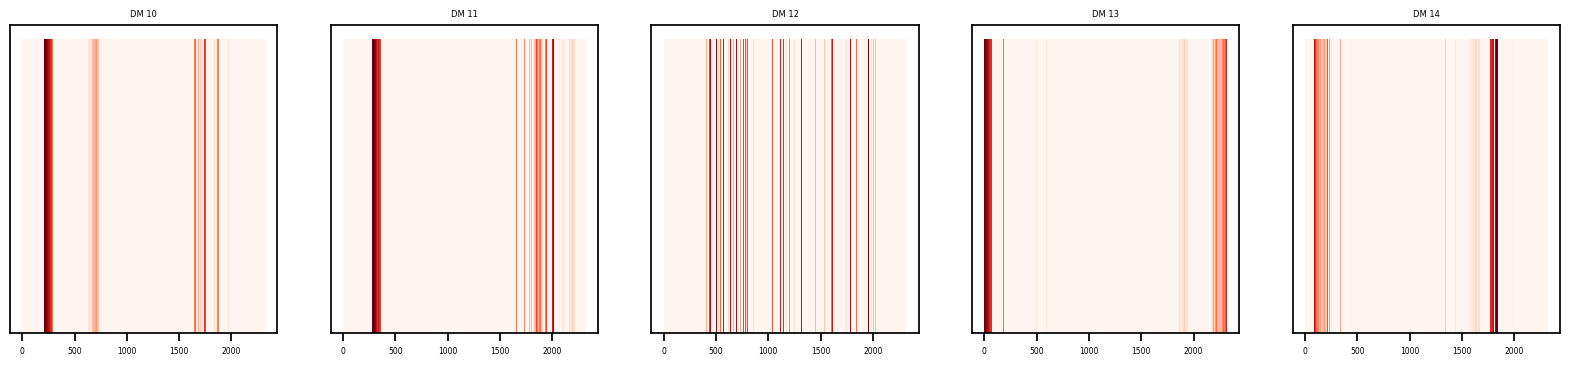

In [16]:
# "African ancestry (%)"
plot_components(diffusion_coords_lb, [0,1,2,3,4], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse,
                admix_labels_custom2[:,1])
plot_components(diffusion_coords_lb, [5,6,7,8,9], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse,
                admix_labels_custom2[:,1])
plot_components(diffusion_coords_lb, [10,11,12,13,14], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse,
                admix_labels_custom2[:,1])

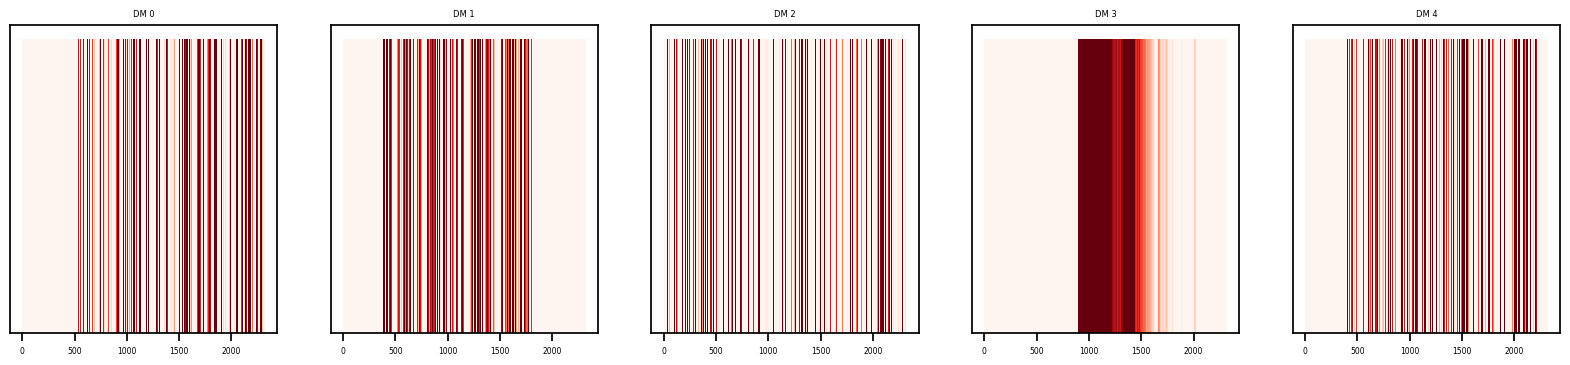

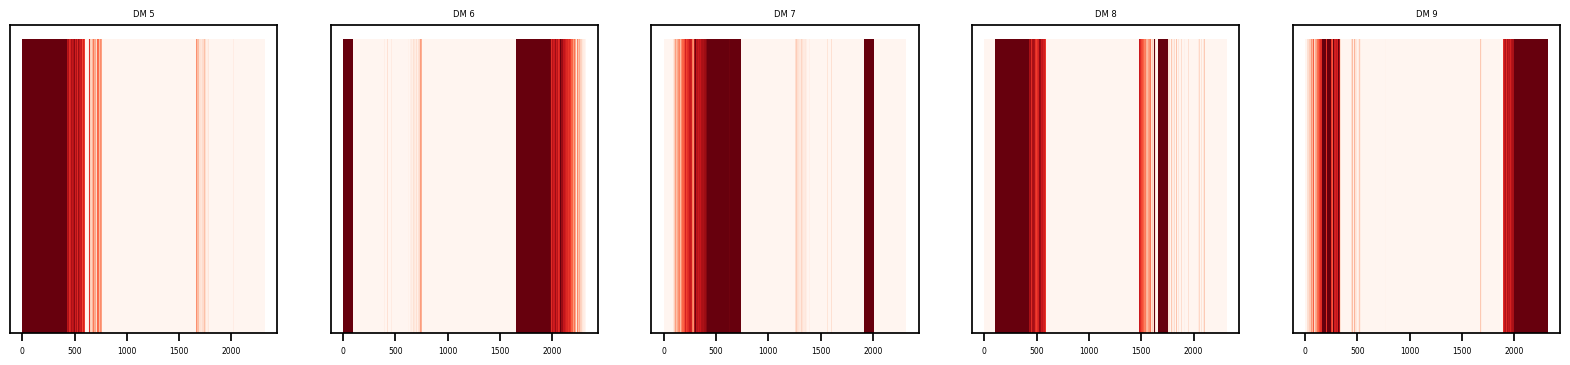

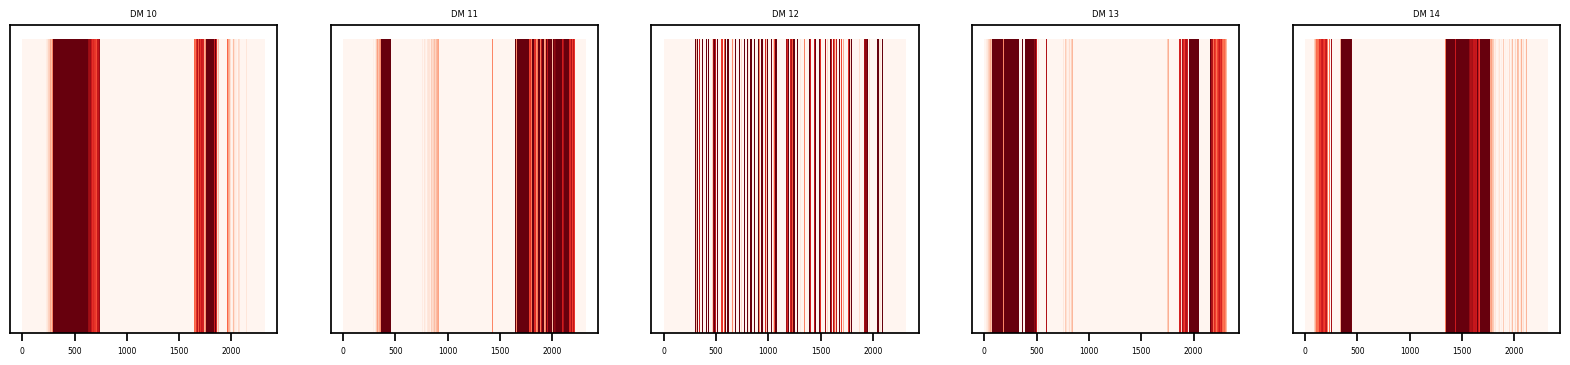

In [17]:
# "European ancestry (%)"
plot_components(diffusion_coords_lb, [0,1,2,3,4], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse,
                admix_labels_custom2[:,2])
plot_components(diffusion_coords_lb, [5,6,7,8,9], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse,
                admix_labels_custom2[:,2])
plot_components(diffusion_coords_lb, [10,11,12,13,14], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse,
                admix_labels_custom2[:,2])

## Remove Admixed Populations

In [18]:
idx_to_use = label_with_superpop_names != 'AMR'

label_with_superpop_names = label_with_superpop_names[idx_to_use]
inputs = inputs[idx_to_use]  
samples = samples[idx_to_use] 
label_with_names = np.array(label_with_names)[idx_to_use]

In [19]:
G = graphtools.Graph(inputs, n_pca=100, n_landmark=None)
K = G.kernel
K = np.array(K.todense())
P = G.diff_op

In [21]:
# alpha=0 Graph Laplacian
evecs_right, evals, P2, d = compute_dm(K, alpha=0)
diffusion_coords = evecs_right@np.diag(evals)

# alpha=0.5 Fokker-Plank operator
evecs_right_fp, evals_fp, P_fp, d_fp = compute_dm(K, alpha=0.5)
diffusion_coords_fp = evecs_right_fp@np.diag(evals_fp)

# alpha=1 Laplace-Beltrami operator
evecs_right_lb, evals_lb, P_lb, d_lb = compute_dm(K, alpha=1)
diffusion_coords_lb = evecs_right_lb@np.diag(evals_lb)

451 eigenvalues are negative: min=-0.2397495189964851
3 eigenvalues are 1
left evec not exactly stationary dist. Proceed with caution!
right evec not trivial (1s)! Proceed with caution!
451 eigenvalues are negative: min=-0.2283708811401364
3 eigenvalues are 1
left evec not exactly stationary dist. Proceed with caution!
right evec not trivial (1s)! Proceed with caution!
451 eigenvalues are negative: min=-0.21693032189772232
3 eigenvalues are 1
left evec not exactly stationary dist. Proceed with caution!
right evec not trivial (1s)! Proceed with caution!


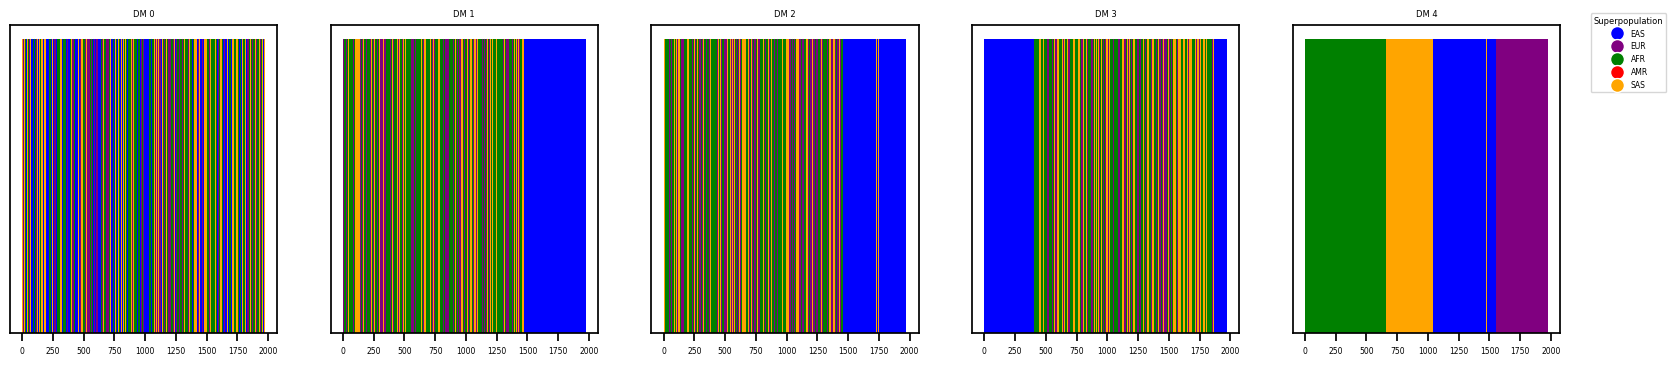

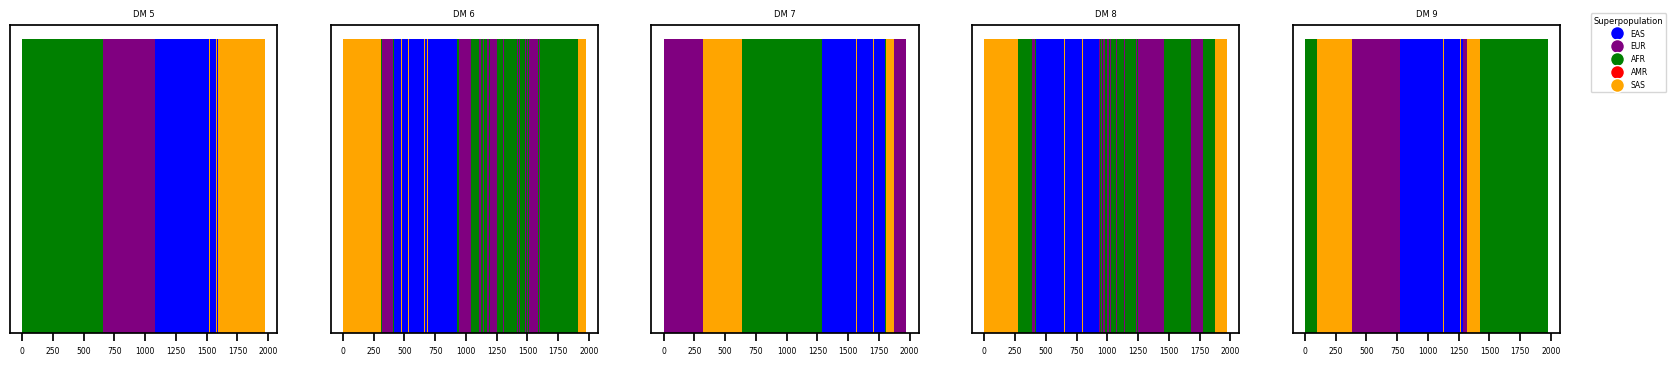

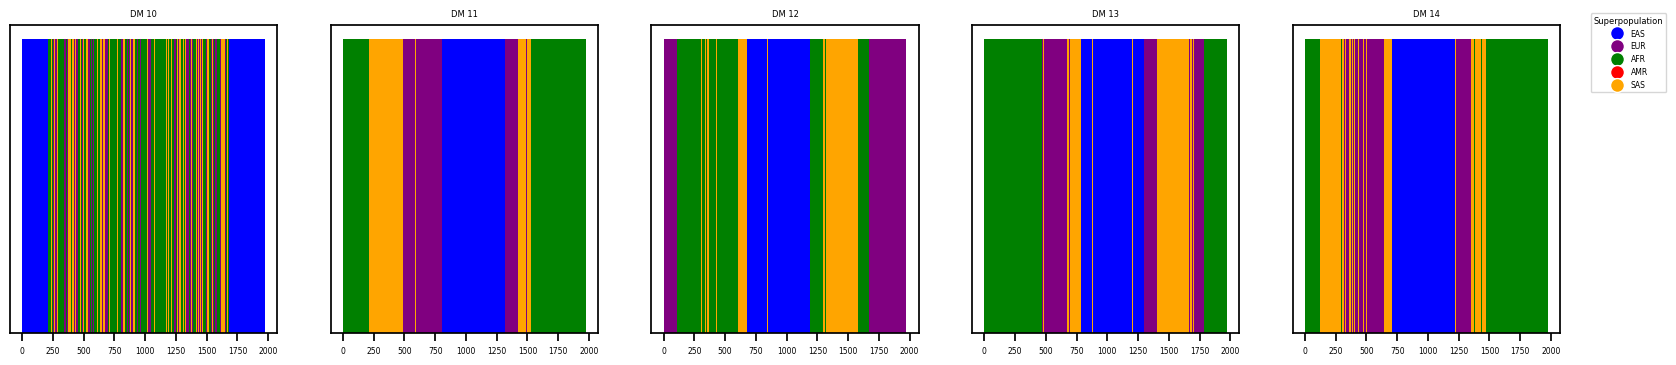

In [22]:
# LB
plot_components(diffusion_coords_lb, [0,1,2,3,4], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)
plot_components(diffusion_coords_lb, [5,6,7,8,9], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)
plot_components(diffusion_coords_lb, [10,11,12,13,14], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)

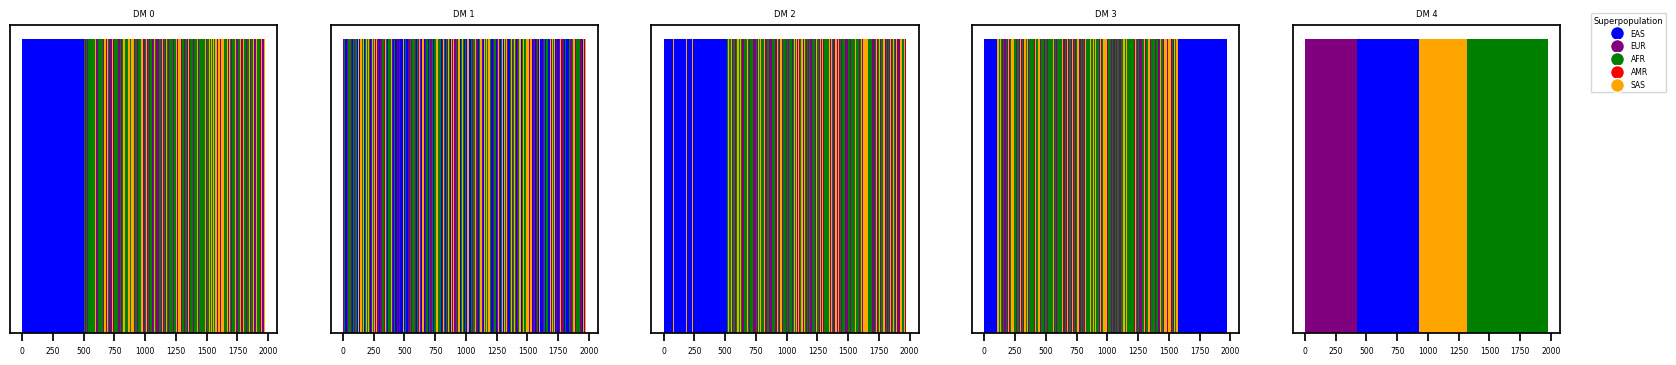

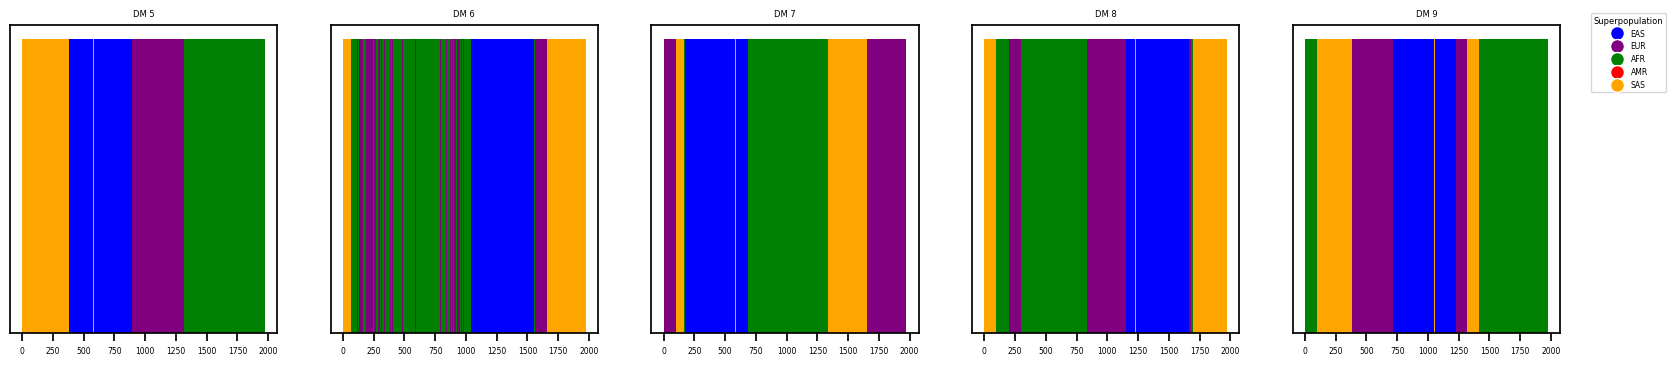

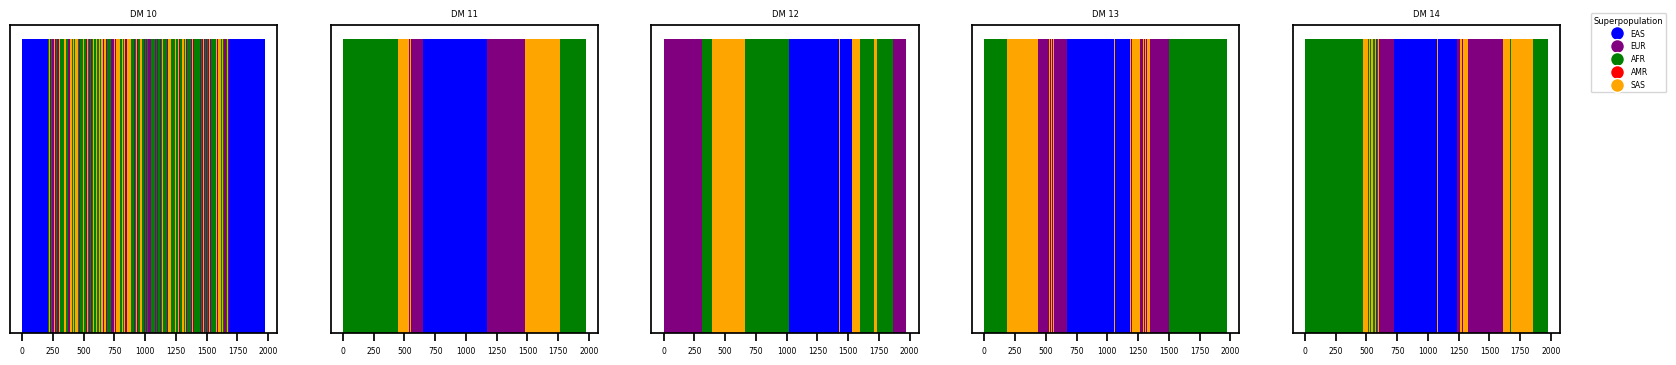

In [23]:
# FP
plot_components(diffusion_coords_fp, [0,1,2,3,4], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)
plot_components(diffusion_coords_fp, [5,6,7,8,9], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)
plot_components(diffusion_coords_fp, [10,11,12,13,14], 
                label_with_superpop_names, 
                mappings.pop_pallette_1000G_coarse,
                mappings.label_order_1000G_coarse)

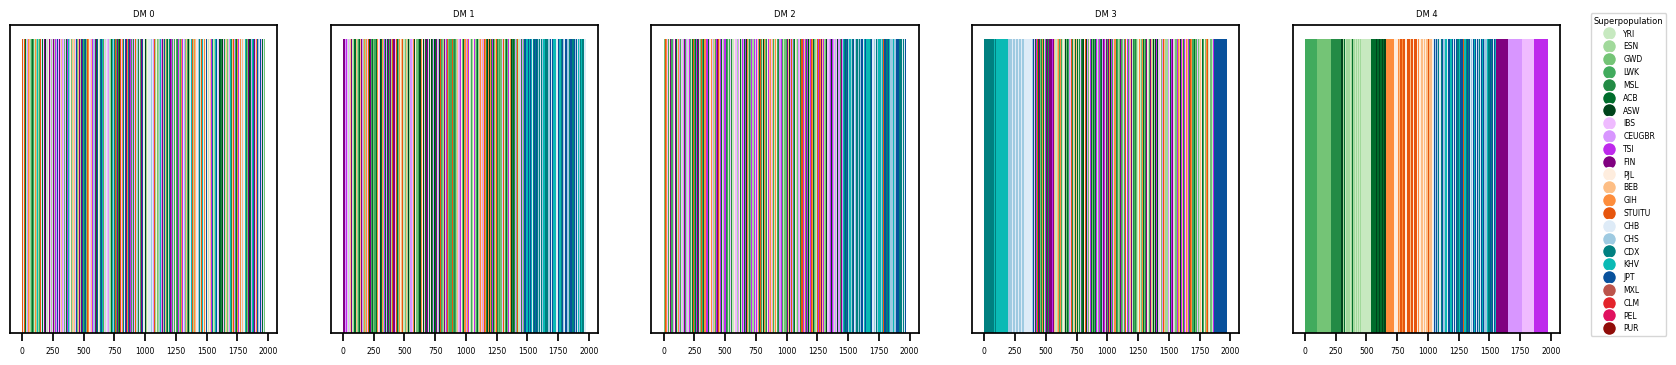

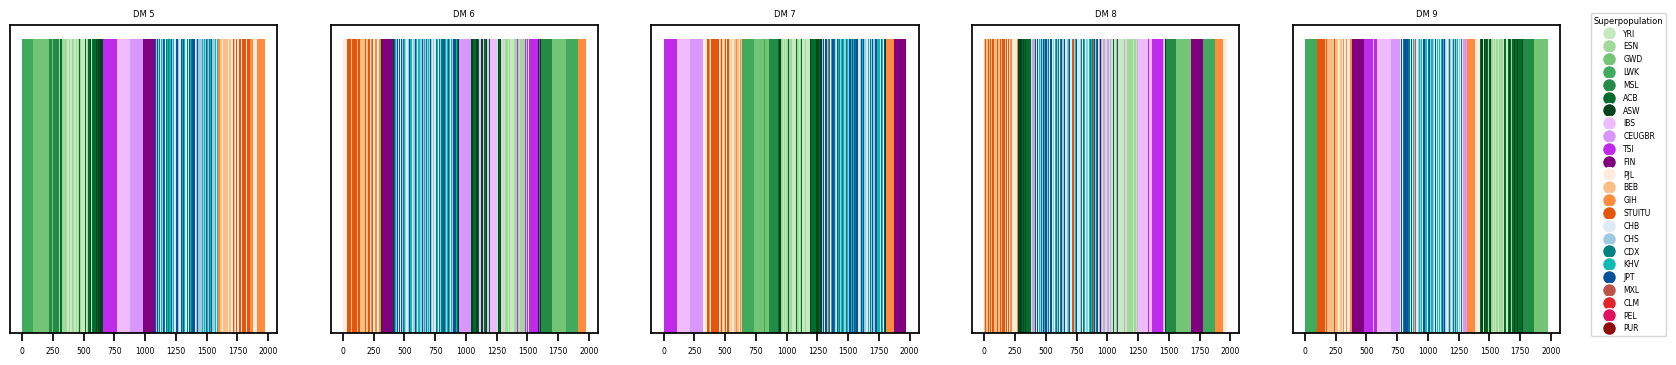

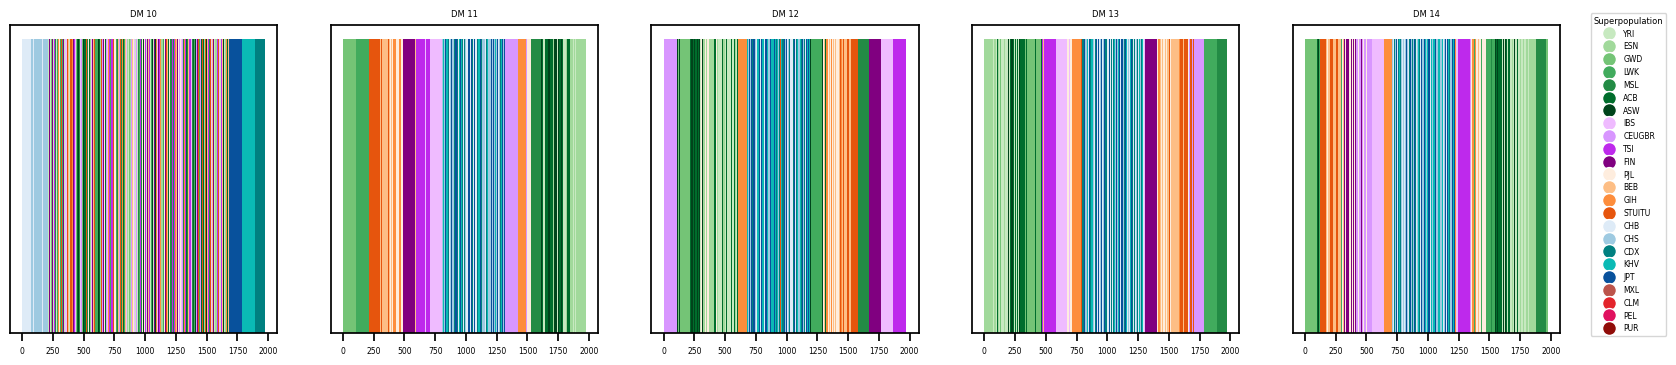

In [24]:
# LB
plot_components(diffusion_coords_lb, [0,1,2,3,4], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)
plot_components(diffusion_coords_lb, [5,6,7,8,9], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)
plot_components(diffusion_coords_lb, [10,11,12,13,14], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)

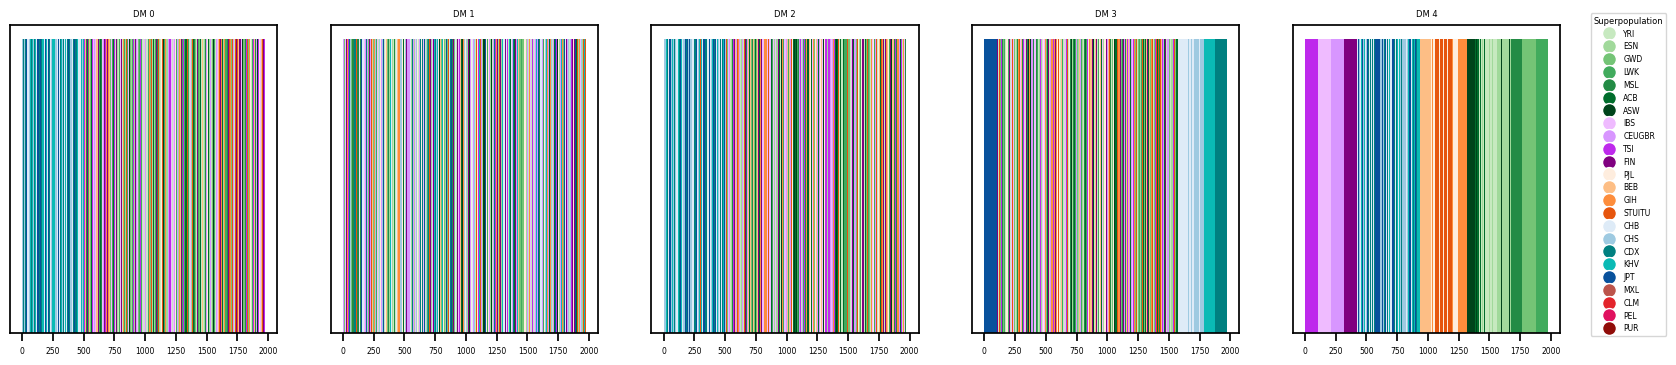

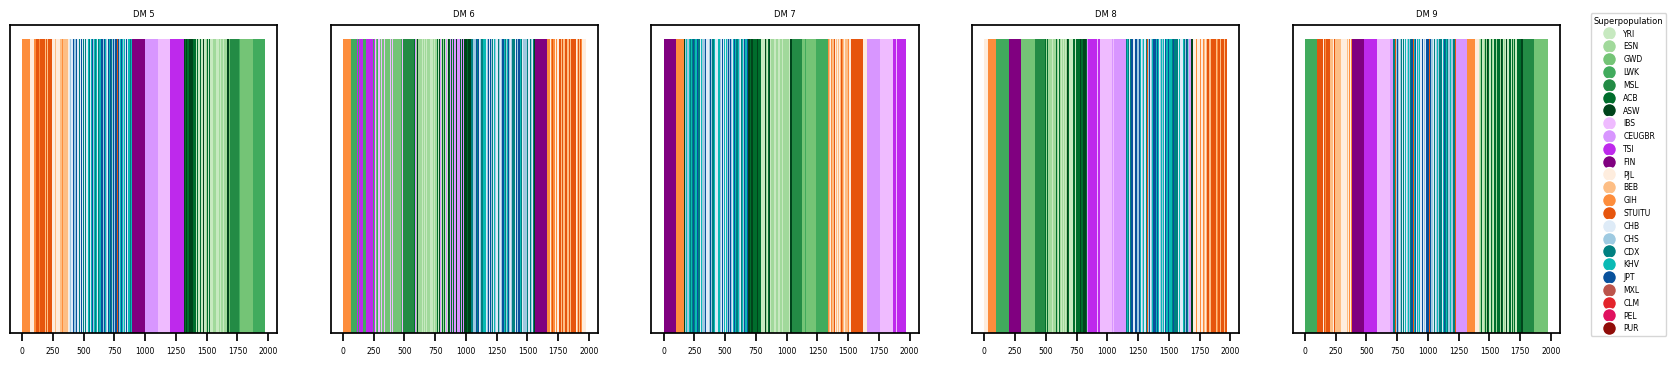

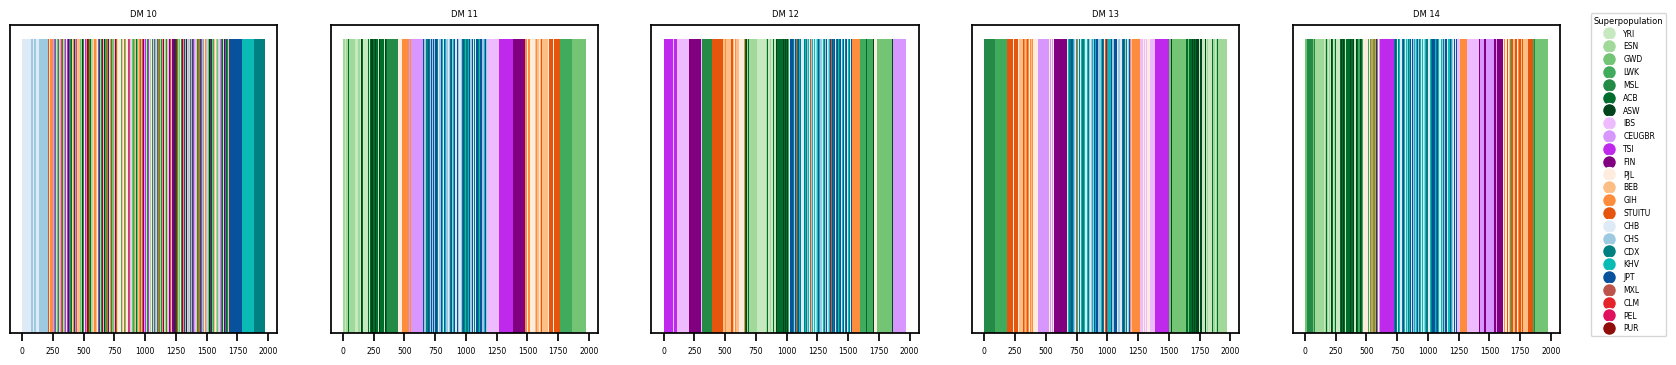

In [25]:
# FP
plot_components(diffusion_coords_fp, [0,1,2,3,4], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)
plot_components(diffusion_coords_fp, [5,6,7,8,9], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)
plot_components(diffusion_coords_fp, [10,11,12,13,14], 
                np.array(label_with_names), 
                mappings.pop_pallette_1000G_fine,
                mappings.label_order_1000G_fine)